# INTRO
Chess is a two-player strategy board game played on an 8x8 checkerboard with 64 square. Played by millions of people worldwide, chess is believed to be derived from the Indian game "chaturanga" sometime before the 7th century. Interestingly, chess has a storied and intraicate history with machine learning. This largely comes from its deterministic nature, and relatively simple ruleset. The combination of these two factors make chess an interesting playground for a host of AI and machine learning algorithms. 

A Brief History of Chess AI:
1951: Alan Turing publishes the first program on paper theoretically capable of playing chess.
1989: Chess world champion Gary Kasparov defeated IBM’s Deep Thought in a chess match.
1996: Kasparov defeated IBM’s Deep Blue in another match.
1997: IBM’s Deep Blue becomes the first chess AI to defeat a grandmaster in a match.
2017: AlphaZero, a neural net-based digital automaton, beats Stockfish 28–0, with 72 draws in chess matches.
2019: Leela Chess Zero (LCZero v0.21.1-nT40.T8.610) defeats Stockfish 19050918 in a 100-game match 53.5 to 46.5 for the Top Chess Engine Championship season 15 title.
Present: Modern chess AI engines deploy deep learning to learn from thousands of matches. They regularly have FIDE ratings, chess’ rating system, above 3,400, far beyond the best human players. 

So obviously there's been a lot of work done on machines designed to play chess at or above the level of the best humans in the world. For the purposes of this project, we'll look at something relatively simple in comparison. If you present a chess player with a board at some state of play, they can fairly quickly determine which side (black or white) is "winning". In some, more complex cases, they may compute some moves ahead to determine this, but usually there is some intutition they have, where they can almost instantly determine which side is winning. In this project I want to see if I can train a computer to do the same thing. 

# Data Aggregation and Cleaning
Let's start with getting some data. Kaggle is a useful database for all kinds of data, and indeed they have a dataset that matches the needs of this project. Thanks to Mitchell J from Kaggle for this dataset: 
https://www.kaggle.com/datasets/datasnaek/chess
This particular dataset collects the records from 20,000 chess games on lichess.com. When we look at the data we see a lot:

In [2]:
import numpy as np
import pandas as pd
import chess as chess

In [3]:
gamesdata = pd.read_csv("archive/games.csv")
gamesdata.axes

[RangeIndex(start=0, stop=20058, step=1),
 Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
        'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
        'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
       dtype='object')]

Interestingly, we don't really care about most of this stuff, really just victory_status, winner, turns, and moves. Let's trim down our data to just these columns.

In [4]:
gamesdata_reduced = gamesdata[["victory_status", "winner", "turns", "moves"]]
gamesdata_reduced


,victory_status,winner,turns,moves
0,outoftime,white,13,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
1,resign,black,16,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...
2,mate,white,61,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
3,mate,white,61,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...
4,mate,white,95,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...
...,...,...,...,...
20053,resign,white,24,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...
20054,mate,black,82,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...
20055,mate,white,35,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...
20056,resign,white,109,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...


Okay, now we have some interesting data to work with. As you can see, we have a little more than 20,000 examples. However, we have a problem! I said earlier we want to look at the board state at some point about halfway through the game, but we don't actually have this information. However, we do have a list of all the moves made throughout the game. We can use this to extrapolate the boardstate, but in order to do this, we need to take a quick detour to explain Standard Algebraic Notation. 

If we look at the first game, we can see the moves as follows:

In [5]:
gamesdata_reduced["moves"][0]

'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

To those not familiar with SAN, this seems like gibberish, but it's actually a pretty simple and effective way to minimally represent moves on a chessboard. To begin with, we can label the rows and columns of a chessboard as follows. 

Now the moves are simple, the first, capital letter refers to the piece being moved (Q is queen, N is knight, B is bishop, and so on). No capital letter means a pawn is being moved. The coordinate refers to the coordinate the piece is being moved to, and an x means that the piece is capturing another piece. For more information on the history and intracacies of SAN, you can refer to the following article from chess.com: 
https://www.chess.com/terms/chess-notation
To interpret this into a board state we can use the chess library for python. This library initializes a default board and implements each ove fed into it. We can then output this into a simple 8 by 8 matrix with capital letters mean white pieces and lowercase letters mean black pieces, in the following way: 

In [6]:
def getboardstate(moves,end):
    board = chess.Board()
    moves = moves.split(" ")
    for move in moves[:end]:
        board.push_san(move)
    boardstate = board.fen().split(" ")[0]
    boardstate = boardstate.split("/")
    for i in range(len(boardstate)): 
        temp = []
        for b in boardstate[i]:
            if b in "123456789":
                temp.extend(["0"] * int(b))
            else:
                temp.append(b)
        boardstate[i] = temp
    return boardstate

print(getboardstate(gamesdata_reduced["moves"][0], gamesdata_reduced["turns"][0]))

[['r', 'n', 'b', 'q', 'k', '0', 'n', 'r'], ['p', 'p', '0', '0', '0', '0', 'p', 'p'], ['0', '0', 'p', '0', 'p', '0', '0', '0'], ['b', '0', '0', '0', '0', '0', '0', '0'], ['0', '0', '0', 'P', '0', 'B', '0', '0'], ['0', '0', 'N', '0', '0', 'N', '0', '0'], ['P', 'P', '0', '0', 'P', 'P', 'P', 'P'], ['R', '0', '0', 'Q', 'K', 'B', '0', 'R']]


For more information about the chess library (which you should do, it's great!), you can visit their Github: 
https://github.com/niklasf/python-chess/blob/master/docs/index.rst


Okay so now we need to define the "mid way" point that we handwaved earlier. Looking at the official data, chess.com claims that there is about 40 turns in an average chess game. When we look at our specific data, we have an average game length of 60 turns. Regardless, let's start by calling the midpoint as half of the total turns being played. Now we can add the boardstate column:

In [7]:
print(np.average(gamesdata_reduced["turns"]))

60.46599860404826


In [8]:
gamesdata_reduced["board_state"] = gamesdata_reduced.apply(lambda row: getboardstate(row["moves"], row["turns"]*8//10), axis = 1)
gamesdata_reduced

C:\Users\Amshe\AppData\Local\Temp\ipykernel_15980\838791010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamesdata_reduced["board_state"] = gamesdata_reduced.apply(lambda row: getboardstate(row["moves"], row["turns"]*8//10), axis = 1)


,victory_status,winner,turns,moves,board_state
0,outoftime,white,13,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,"[[r, n, b, q, k, 0, n, r], [p, p, 0, 0, 0, 0, ..."
1,resign,black,16,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,"[[r, 0, b, q, k, b, n, r], [p, p, p, p, 0, 0, ..."
2,mate,white,61,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, P, ..."
3,mate,white,61,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,"[[0, 0, 0, 0, 0, b, 0, r], [R, 0, 0, 0, 0, Q, ..."
4,mate,white,95,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,"[[0, 0, 0, 0, 0, 0, 0, 0], [p, R, 0, 0, 0, 0, ..."
...,...,...,...,...,...
20053,resign,white,24,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,"[[r, n, 0, q, k, 0, 0, r], [p, b, p, 0, b, 0, ..."
20054,mate,black,82,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,"[[0, 0, 0, 0, 0, 0, k, 0], [Q, 0, 0, 0, 0, p, ..."
20055,mate,white,35,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,"[[r, 0, b, q, 0, r, 0, k], [p, 0, p, n, b, 0, ..."
20056,resign,white,109,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, k, 0, 0, ..."


Okay now we have the data we need, but this isn't something we can use as input for our algorithm. I think a good place to start would be taking a play out of the computer vision playbook. Essentially we can unravel the 8x8 matrix into a single, 64x1 column vector. Now, each row has a value corresponding to a specific piece. Instread of looking at each piece as a value, let's conver it to a 1-hot vector of size 12 (there are 6 unique pieces per side, so 12 total on the board). Then we can unravel this 64x12 matrix again, now into a 768x1 column vector. 

In [9]:
letter_to_value = {"r":0, "n":1,"b":2,"q":3,"k":4,"p":5,"R":6,"N":7,"B":8,"Q":9,"K":10,"P":11}

In [10]:

def convert_to_column_vector(boardstate):
    col_vec_64 = np.array(boardstate).flatten()
    mat_64_8 = np.zeros((64,12))
    for i in range(len(col_vec_64)):
        if(col_vec_64[i] in letter_to_value.keys()):
            mat_64_8[i][letter_to_value.get(col_vec_64[i])] = 1
    return mat_64_8.flatten()
                
        

print(convert_to_column_vector(gamesdata_reduced["board_state"][0]))
print(convert_to_column_vector(gamesdata_reduced["board_state"][0]).shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [11]:
gamesdata_reduced["single_col"] = gamesdata_reduced.apply(lambda row: convert_to_column_vector(row["board_state"]), axis = 1)
gamesdata_reduced["single_col"][0]

C:\Users\Amshe\AppData\Local\Temp\ipykernel_15980\2586317653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamesdata_reduced["single_col"] = gamesdata_reduced.apply(lambda row: convert_to_column_vector(row["board_state"]), axis = 1)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.

We have our input, now our final step of prepearation is we need output. The outcome of a chess game is a relatively simple: black win, white win, or draw. Let's check the numbers on each of these:

In [11]:
print(gamesdata_reduced["winner"].value_counts())

white    10001
black     9107
draw       950
Name: winner, dtype: int64


So we can see clearly that draws are in the extreme minority, with white wins about 10% more likely than black wins. To begin with, let's just look at the games with a winner (not a draw). We will come back to the draws, and make sure to include them in our final model. For now, let's work with just the games with an actual winner. 

In [12]:
gamesdata_binary = gamesdata_reduced.loc[gamesdata_reduced["winner"] != "draw"]
gamesdata_binary["winner"].value_counts()

white    10001
black     9107
Name: winner, dtype: int64

For these, let's set white wins as 1 and black wins as 0.

In [13]:
gamesdata_binary["binary_winner"] = gamesdata_binary.apply(lambda row: 0 if row["winner"] == "black" else 1, axis = 1)
gamesdata_binary["binary_winner"].value_counts()

C:\Users\Amshe\AppData\Local\Temp\ipykernel_15980\3210152118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamesdata_binary["binary_winner"] = gamesdata_binary.apply(lambda row: 0 if row["winner"] == "black" else 1, axis = 1)


1    10001
0     9107
Name: binary_winner, dtype: int64

# Data Modeling
Finally! We now have a classic binary classification problem. Let's start with the basics and build a perceptron. We can use sklearn's perceptron class. For an overview of a what a perceptron is, you can check out the following website: 
https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron
If you don't want to do that, I'll give you a quick overview. A perceptron is a simple machine learning algorithm that looks to find the division boundary between two categories of data. Importantly, the data has to be linearly separable, because the perceptron can only draw a linear boundary. Our data is in too high of a dimension to be graphed comprehensibly, so let's apply Principal Component Analysis to reduce the data into something we can graph, to get an estimation of the separability. 

In [14]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from matplotlib import pyplot as plt
X = np.vstack(gamesdata_binary["single_col"])
transformer = IncrementalPCA(n_components = 2, batch_size = 100)
transformer.fit(X)
X_transformed = transformer.fit_transform(X)


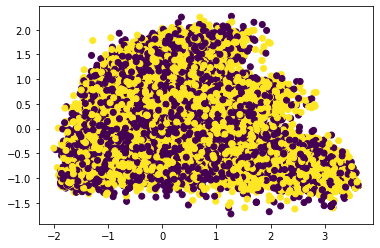

In [15]:

plt.scatter(X_transformed[:,0], X_transformed[:,1],c = gamesdata_binary["binary_winner"])

So this is not seem to be linearly separable, so we ccan assume a perceptron will not be effective. Still, let's try it anyways and see how it performs. We'll set 20% of the dataset to be the test set, and we can use sklearn's Perceptron class. 

In [14]:
from sklearn.model_selection import train_test_split
data = np.vstack(gamesdata_binary["single_col"])
datasets = train_test_split(data, gamesdata_binary["binary_winner"],
                            test_size=0.2)

train_data, test_data, train_labels, test_labels = datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
p = Perceptron(random_state=42, verbose=0)
p.fit(train_data, train_labels)
predictions_train = p.predict(train_data)
predictions_test = p.predict(test_data)
train_score = accuracy_score(predictions_train, train_labels)
print("score on train data: ", train_score)
test_score = accuracy_score(predictions_test, test_labels)
print("score on test data: ", test_score)

score on train data:  0.7009682062017533
score on test data:  0.6656200941915228


The accuracy is only about 60%, which at first might seem pretty good compared to randomly guessing (since we'd presume this to have an accuracy of 50%), but in fact it's not. In reality, chess is biased towards white, by about 10%. As such, in the data, white wins 60% of the time. Consequently, if one was just to always predict white, they'd be right about 60% of the time. As such, this is not very insightful. 

Now we know that a linear classifier isn't effective, let's try a more complicated model. Let's start with a simple neural network with a single hidden layer of size 612. This size was chosen as it is a power of 2, a little smaller than the input size. Moreover, the network uses the ReLU function to activate the neurons, and because we're dealing with categorical data we'll use Cross Entropy Loss. To optimize we can use the Adam optimizer, and we'll use Sklearn to run all of this. 

But before we can train we need to divide our data into train and test sets, which we can do again with Sklearn. We'll set aside 20% of the dataset as the test set, and use the other 80% to train. 

But before any of this we should first just convert all the output data to one hot vectors

In [17]:
def conv_to_one_hot(str):
    if str == "black":
        return [0.0,1.0,0.0]
    elif str == "white":
        return [1.0,0.0,0.0]
    else:
        return [0.0,0.0,1.0]

In [18]:
gamesdata_reduced["onehot_output"] = gamesdata_reduced.apply(lambda row: conv_to_one_hot(row["winner"]), axis = 1)
gamesdata_reduced["onehot_output"].value_counts()

C:\Users\Amshe\AppData\Local\Temp\ipykernel_15980\4145399837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamesdata_reduced["onehot_output"] = gamesdata_reduced.apply(lambda row: conv_to_one_hot(row["winner"]), axis = 1)


[1.0, 0.0, 0.0]    10001
[0.0, 1.0, 0.0]     9107
[0.0, 0.0, 1.0]      950
Name: onehot_output, dtype: int64

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.vstack(gamesdata_reduced["single_col"]), np.vstack(gamesdata_reduced["onehot_output"]), test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a neural network classifier
model = MLPClassifier(hidden_layer_sizes=(600), activation='relu', solver='adam', early_stopping=True)

# Train the model
model.fit(X_train, y_train)



MLPClassifier(early_stopping=True, hidden_layer_sizes=600)

So now let's see what this looks like in terms of accuracy:

In [20]:
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.636839481555334


This is an improvement, but I think we can do better. Let's check how changing the size of the hidden layer affects accuracy. 

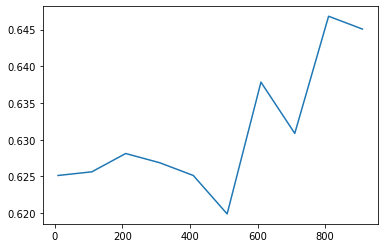

In [21]:
hidden_sizes = []
accuracies = []

for i in range(10,1000,100):
    model = MLPClassifier(hidden_layer_sizes=(i), activation='relu', solver='adam', early_stopping=True)
    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))
    hidden_sizes.append(i)

plt.plot(hidden_sizes, accuracies)

So this is somewhat useful, we see that a hidden layer of size 810 appears to be the most effective. Let's look into the learning rate next:

In [26]:
learning_rates = []
accuracies = []

for i in range(1,10):
    model = MLPClassifier(hidden_layer_sizes=(810), activation='relu', solver='adam', early_stopping=True, learning_rate_init= 1/(10**i))
    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))
    learning_rates.append(1/(10**i))

plt.plot(learning_rates, accuracies)

: 

: 

So now we have two hyperparamters optimized, so let's look at the confusion matrix we get. 

In [34]:
def vec_to_string(vec):
    ret = []
    for v in vec:
        if v[0] == 1:
            ret.append("white")
        elif v[1] == 1:
            ret.append("black")
        else:
            ret.append("tie")
    
    return ret

In [39]:
from torchmetrics import ConfusionMatrix 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
pred_test = model.predict(X_test)

preds = vec_to_string(pred_test)
reals = vec_to_string(y_test)
cm = confusion_matrix(preds, reals)

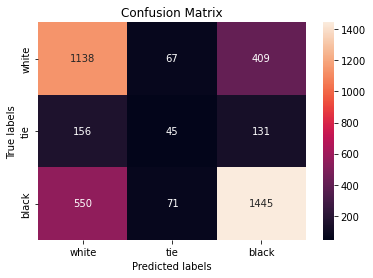

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['white', 'tie', 'black']); ax.yaxis.set_ticklabels(['white', 'tie', 'black']);

This gives us sometihng to analyze. Interestingly, white was predicted the most, followed by black, and then tie. This follows the order of prevalence inthe dataset, so this is not an unexpected outcome. Interestingly, the model appears to be about as good at identifying blakck as white, but appears to be quite bad at predicting ties. The model predicts black and white correctly more than incorrectly, but it guesses a tie correctly less than half the time. 

# Conclusion
Interestingly, we finished with an accuracy of just a little shy of 70%. This isn't a bad accuracy, but it's not perfect. Given a board at such a state, a high-level chess player can make a prediction at an accuracy far higher than 67%. This begs the natural question, why?

There's a couple of options: lack of data, external factors, and elo imbalance. We can talk about each of these in depth.

First, there comes the issue of a lack of data. We used a dataset of about 20,000 example games. There is a lot of interesting math done on this (here's an article to start with: https://www.liverpoolmuseums.org.uk/stories/which-greater-number-of-atoms-universe-or-number-of-chess-moves). But conservatively, there's 10^17 possible chess positions. In that sense, even if we assume that all 20,000 games in the dataset are unique, we're still just at a drop in the metaphorical bucket. 

Second, there comes the issue of external factors. We only looked at the positions of pieces on the board, but it's reasonable to assume that other factors might also be at play here. The outcome of a game could be determined (or at least influenced) by time constraints, or a player's personal bias. Moreover, these games are all online, recreational games. As such it is possible that players are distracted or not trying as hard as they could. 

Finally, there's the issue of elo imbalance. These games, although played between players of approximately equal skill, come from a variety of elos. While it is reasonable to assume tht a high level player could maximize every position, this is not the case for lower level players. A lower level player is more likely to make mistakes. These taint they integrity of the dataset, as a winning position might not be closed out, making the model think that the winning position is in fact losing.

If I were to continue this project, these are all things that I would consider. I would look for a bigger dataset, and eliminate lower level gameplay, limiting all games in the dataset to something like >2000 elo. 